## 1. Import der benötigten Bibliotheken

In [47]:
# Installiere benötigte Pakete (nur beim ersten Mal ausführen)
import sys
!{sys.executable} -m pip install -q scipy seaborn matplotlib pymysql sqlalchemy

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [63]:
# Datenverarbeitung
import pandas as pd
import numpy as np

# Statistische Tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr, f_oneway

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Import utility functions from db_utils
from db_utils import read_from_db, setup_display_settings, setup_visualization_settings

# Einstellungen für bessere Darstellung
setup_display_settings(float_format='{:.2f}', precision=2)
setup_visualization_settings()

print("Alle Bibliotheken erfolgreich importiert")

✅ Display settings configured
✅ Visualization settings configured
Alle Bibliotheken erfolgreich importiert


## 2. Daten laden

In [49]:
# Laden der Daten DIREKT aus der MySQL Datenbank
df = read_from_db("SELECT * FROM wanderwege")

print(f"Datensatz aus Datenbank geladen: {df.shape[0]} Wanderwege, {df.shape[1]} Variablen")

✅ Loaded 375 rows, 13 columns from database
Datensatz aus Datenbank geladen: 375 Wanderwege, 13 Variablen


In [50]:
# Überblick über die Datentypen und fehlende Werte
print("Datentypen und fehlende Werte:")
df.info()

Datentypen und fehlende Werte:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               375 non-null    object 
 1   title             375 non-null    object 
 2   location          375 non-null    object 
 3   canton            372 non-null    object 
 4   difficulty_level  101 non-null    object 
 5   difficulty_num    101 non-null    float64
 6   duration_min      372 non-null    float64
 7   distance_km       375 non-null    float64
 8   ascent_m          373 non-null    float64
 9   descent_m         372 non-null    float64
 10  physical_demand   375 non-null    object 
 11  latitude          342 non-null    float64
 12  longitude         342 non-null    float64
dtypes: float64(7), object(6)
memory usage: 38.2+ KB


---
# Test 1: Korrelationsanalyse

**Ziel:** Untersuchen des linearen Zusammenhangs zwischen numerischen Variablen

**Hypothesen:**
- H₀ (Nullhypothese): Es gibt keinen Zusammenhang zwischen den Variablen (Korrelation = 0)
- H₁ (Alternativhypothese): Es gibt einen Zusammenhang zwischen den Variablen (Korrelation ≠ 0)

**Interpretation des p-Werts:**
- p < 0.05: Der Zusammenhang ist statistisch signifikant
- p ≥ 0.05: Kein signifikanter Zusammenhang nachweisbar

## 1.1 Auswahl der numerischen Variablen

In [51]:
# Auswahl relevanter numerischer Spalten für die Korrelationsanalyse
numerical_cols = ['distance_km', 'duration_min', 'ascent_m', 'descent_m', 'latitude', 'longitude']

# Prüfen, welche Spalten tatsächlich vorhanden sind
available_cols = [col for col in numerical_cols if col in df.columns]

print(f"Verfügbare numerische Variablen: {available_cols}")
print(f"\nAnzahl: {len(available_cols)} Variablen")

# Deskriptive Statistik
df[available_cols].describe()

Verfügbare numerische Variablen: ['distance_km', 'duration_min', 'ascent_m', 'descent_m', 'latitude', 'longitude']

Anzahl: 6 Variablen


,distance_km,duration_min,ascent_m,descent_m,latitude,longitude
count,375.00,372.00,373.00,372.00,342.00,342.00
mean,8.72,182.18,314.03,351.10,46.97,8.30
std,3.73,75.10,187.99,221.82,1.24,2.08
min,0.00,35.00,0.00,5.00,43.04,-4.73
25%,5.85,130.00,175.00,190.00,46.48,7.46
50%,8.40,175.00,290.00,315.00,46.82,8.16
75%,11.10,220.00,420.00,461.25,47.17,9.03
max,24.30,435.00,1080.00,1310.00,58.89,25.57


## 1.2 Pairplot - Visueller Überblick über alle Beziehungen

Visueller Überblick über alle Beziehungen zwischen den numerischen Variablen:



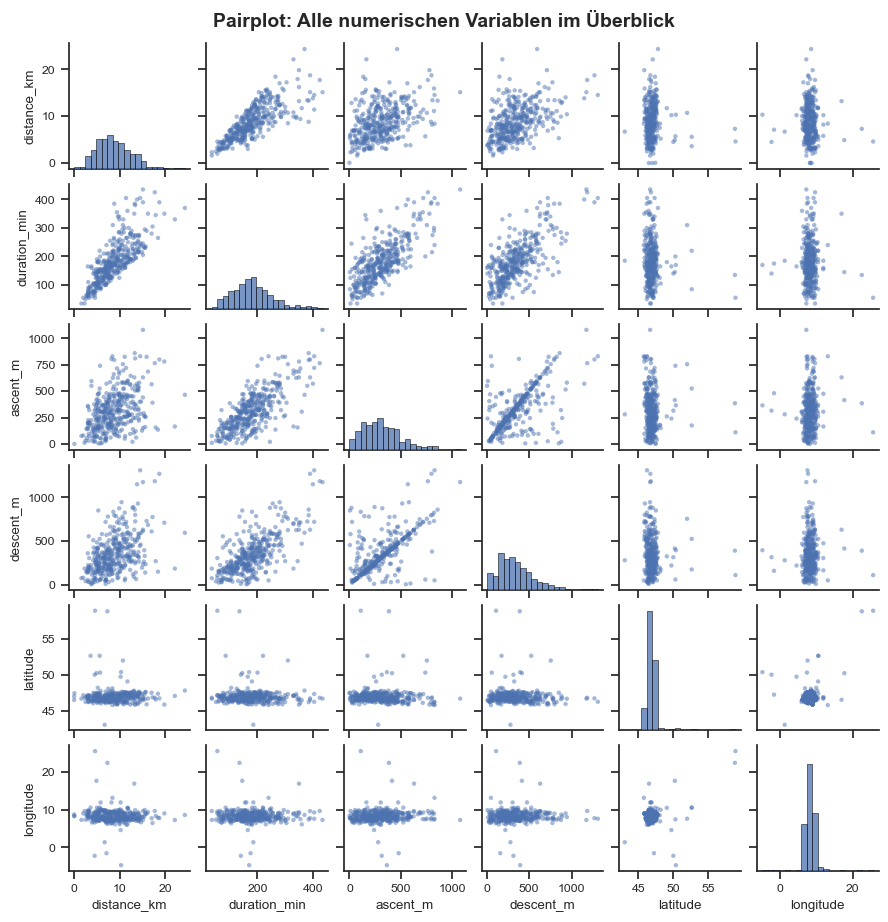


Interpretation:
- Diagonale: Histogramme zeigen die Verteilung jeder Variable
- Außerhalb Diagonale: Scatterplots zeigen Beziehungen zwischen Variablenpaaren
- Lineare Muster deuten auf Korrelationen hin


In [52]:
# Pairplot für visuellen Überblick über alle Beziehungen
print("Visueller Überblick über alle Beziehungen zwischen den numerischen Variablen:\n")

# Seaborn-Einstellungen für den Pairplot
sns.set(style="ticks", font_scale=0.8)

# Erstelle Pairplot
g = sns.pairplot(df[available_cols], 
                 height=1.5, 
                 aspect=1,
                 plot_kws={'alpha':0.5, 's':10, 'edgecolor':'none'},
                 diag_kws={'bins':20, 'edgecolor':'black'})

# Titel hinzufügen
g.fig.suptitle('Pairplot: Alle numerischen Variablen im Überblick', y=1.02, fontsize=14, fontweight='bold')

plt.show()

print("\nInterpretation:")
print("- Diagonale: Histogramme zeigen die Verteilung jeder Variable")
print("- Außerhalb Diagonale: Scatterplots zeigen Beziehungen zwischen Variablenpaaren")
print("- Lineare Muster deuten auf Korrelationen hin")

## 1.2 Pearson-Korrelationsmatrix (mit p-Werten)

Pearson-Korrelationsmatrix:
              distance_km  duration_min  ascent_m  descent_m  latitude  longitude
distance_km          1.00          0.78      0.41       0.47     -0.03      -0.06
duration_min         0.78          1.00      0.74       0.70     -0.08      -0.02
ascent_m             0.41          0.74      1.00       0.64     -0.03       0.06
descent_m            0.47          0.70      0.64       1.00     -0.06       0.03
latitude            -0.03         -0.08     -0.03      -0.06      1.00       0.43
longitude           -0.06         -0.02      0.06       0.03      0.43       1.00


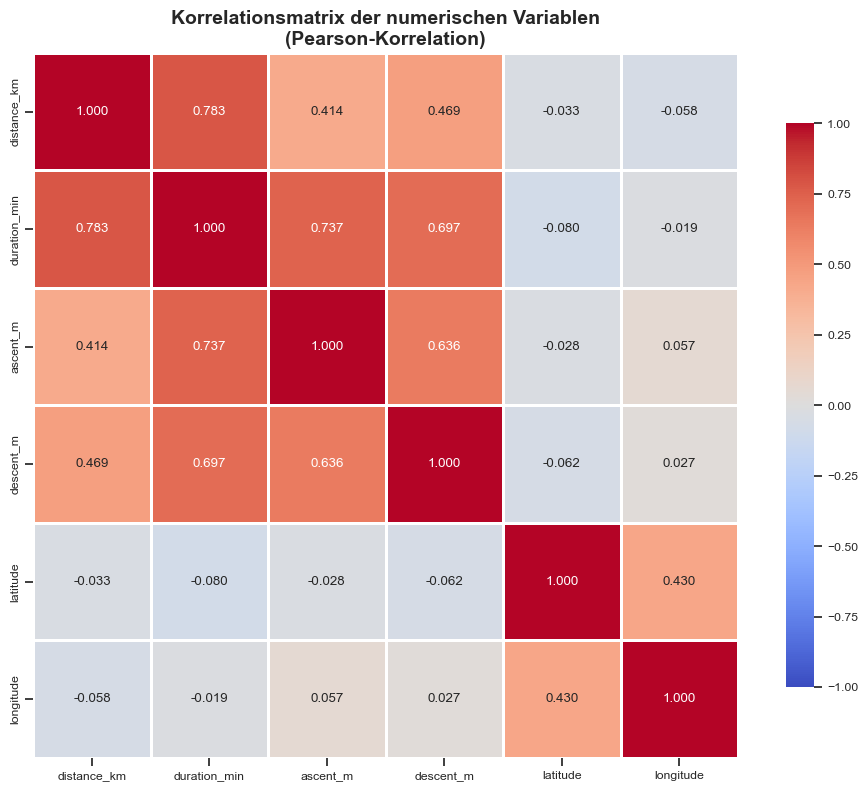

In [53]:
# Berechnung der Pearson-Korrelationsmatrix
correlation_matrix = df[available_cols].corr(method='pearson')

print("Pearson-Korrelationsmatrix:")
print(correlation_matrix)

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Korrelationsmatrix der numerischen Variablen\n(Pearson-Korrelation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.3 Detaillierte Korrelationsanalyse mit p-Werten

p-Wert Matrix (Signifikanz der Korrelationen):
              distance_km  duration_min  ascent_m  descent_m  latitude  longitude
distance_km          0.00          0.00      0.00       0.00      0.55       0.29
duration_min         0.00          0.00      0.00       0.00      0.14       0.73
ascent_m             0.00          0.00      0.00       0.00      0.60       0.29
descent_m            0.00          0.00      0.00       0.00      0.25       0.62
latitude             0.55          0.14      0.60       0.25      0.00       0.00
longitude            0.29          0.73      0.29       0.62      0.00       0.00


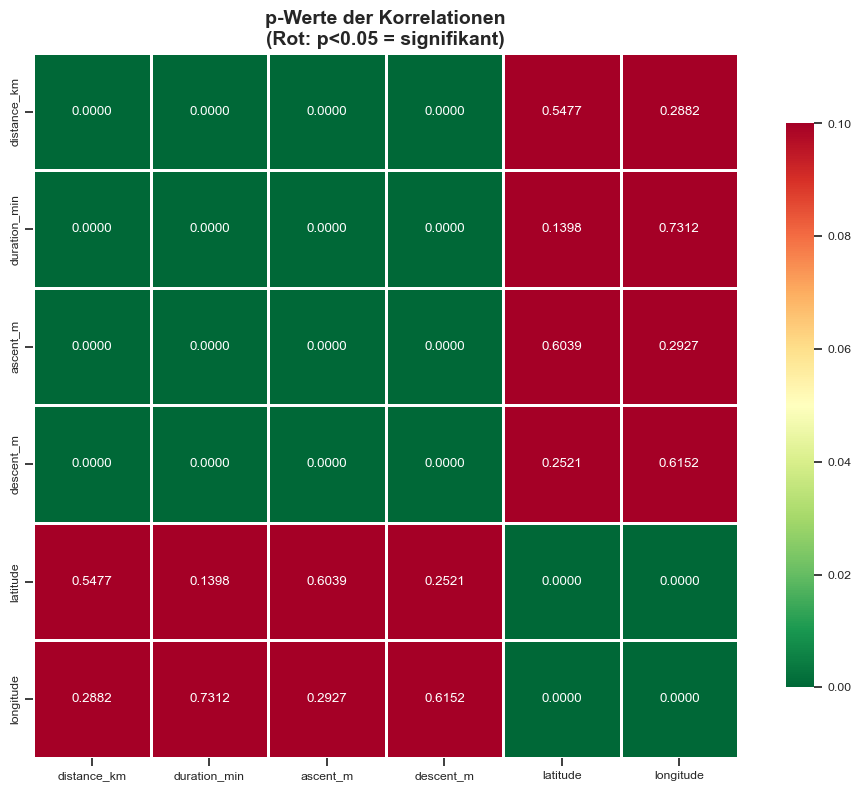


Interpretation: p < 0.05 bedeutet statistisch signifikante Korrelation


In [54]:
# Funktion zur Berechnung von Korrelation und p-Wert für alle Paare
def calculate_pvalues(df, cols):
    """
    Berechnet p-Werte für alle Korrelationspaare
    """
    n = len(cols)
    pval_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                pval_matrix[i, j] = 0  # Diagonale
            else:
                # Entferne NaN-Werte für jedes Paar
                valid_data = df[[cols[i], cols[j]]].dropna()
                if len(valid_data) > 2:
                    _, p_value = pearsonr(valid_data[cols[i]], valid_data[cols[j]])
                    pval_matrix[i, j] = p_value
                else:
                    pval_matrix[i, j] = 1.0
    
    return pd.DataFrame(pval_matrix, columns=cols, index=cols)

# Berechne p-Werte
pvalue_matrix = calculate_pvalues(df, available_cols)

print("p-Wert Matrix (Signifikanz der Korrelationen):")
print(pvalue_matrix)

# Visualisierung der p-Werte
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, 
            annot=True, 
            fmt='.4f', 
            cmap='RdYlGn_r',  # Rot = signifikant, Grün = nicht signifikant
            center=0.05,
            vmin=0, 
            vmax=0.1,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('p-Werte der Korrelationen\n(Rot: p<0.05 = signifikant)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation: p < 0.05 bedeutet statistisch signifikante Korrelation")

## 1.4 Signifikante Korrelationen identifizieren

In [55]:
# Erstelle eine Übersicht der signifikanten Korrelationen
print("="*80)
print("SIGNIFIKANTE KORRELATIONEN (p < 0.05)")
print("="*80)

results = []
for i in range(len(available_cols)):
    for j in range(i+1, len(available_cols)):  # Nur obere Dreiecksmatrix
        col1 = available_cols[i]
        col2 = available_cols[j]
        corr = correlation_matrix.loc[col1, col2]
        pval = pvalue_matrix.loc[col1, col2]
        
        if pval < 0.05:
            results.append({
                'Variable 1': col1,
                'Variable 2': col2,
                'Korrelation': corr,
                'p-Wert': pval,
                'Signifikant': 'Ja' if pval < 0.05 else 'Nein'
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Korrelation', key=abs, ascending=False)

if len(results_df) > 0:
    print(f"\nAnzahl signifikanter Korrelationen: {len(results_df)}\n")
    print(results_df.to_string(index=False))
else:
    print("\nKeine signifikanten Korrelationen gefunden.")

print("\n" + "="*80)

SIGNIFIKANTE KORRELATIONEN (p < 0.05)

Anzahl signifikanter Korrelationen: 7

  Variable 1   Variable 2  Korrelation  p-Wert Signifikant
 distance_km duration_min         0.78    0.00          Ja
duration_min     ascent_m         0.74    0.00          Ja
duration_min    descent_m         0.70    0.00          Ja
    ascent_m    descent_m         0.64    0.00          Ja
 distance_km    descent_m         0.47    0.00          Ja
    latitude    longitude         0.43    0.00          Ja
 distance_km     ascent_m         0.41    0.00          Ja



## 1.5 Beispiel: Detaillierte Analyse einer starken Korrelation

Detaillierte Analyse: distance_km vs. duration_min
Korrelation: 0.7828
p-Wert: 0.000000


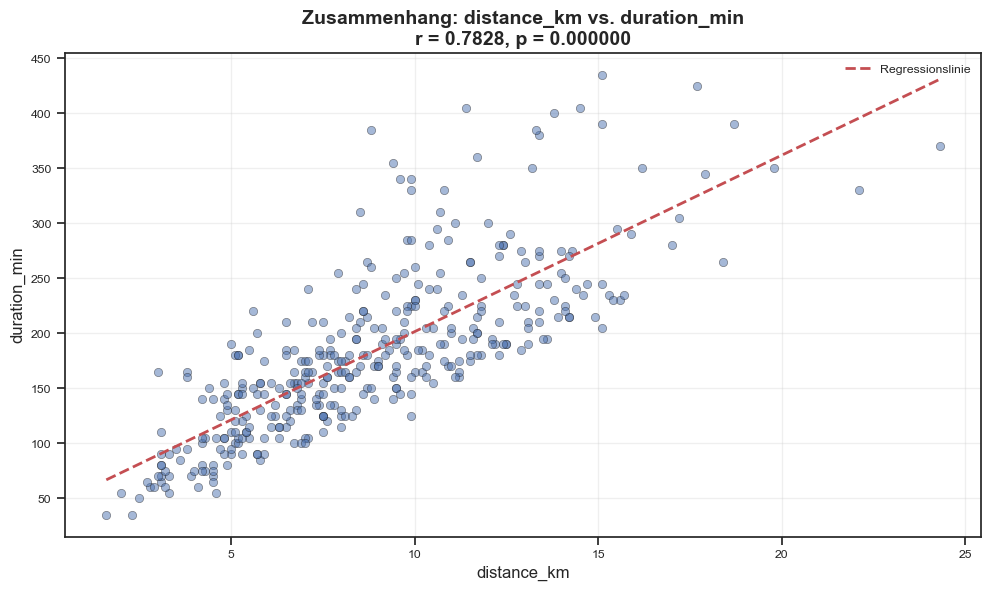

In [56]:
# Wähle die stärkste Korrelation für detaillierte Analyse
if len(results_df) > 0:
    strongest = results_df.iloc[0]
    var1 = strongest['Variable 1']
    var2 = strongest['Variable 2']
    
    print(f"Detaillierte Analyse: {var1} vs. {var2}")
    print(f"Korrelation: {strongest['Korrelation']:.4f}")
    print(f"p-Wert: {strongest['p-Wert']:.6f}")
    
    # Filter für gültige Daten in beiden Spalten
    valid_data = df[[var1, var2]].dropna()
    x_data = valid_data[var1]
    y_data = valid_data[var2]
    
    # Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, alpha=0.5, edgecolors='k', linewidth=0.5)
    
    # Regressionslinie
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x_data)
    plt.plot(x_sorted, p(x_sorted), "r--", linewidth=2, label='Regressionslinie')
    
    plt.xlabel(var1, fontsize=12)
    plt.ylabel(var2, fontsize=12)
    plt.title(f'Zusammenhang: {var1} vs. {var2}\nr = {strongest["Korrelation"]:.4f}, p = {strongest["p-Wert"]:.6f}', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Keine signifikanten Korrelationen für detaillierte Analyse verfügbar.")

---
# Test 2: ANOVA (Analysis of Variance)

**Ziel:** Testen ob es signifikante Unterschiede in einer numerischen Variable zwischen verschiedenen Gruppen gibt

**Beispiel:** Gibt es signifikante Unterschiede in der Wanderlänge zwischen verschiedenen Kantonen?

**Hypothesen:**
- H₀ (Nullhypothese): Alle Gruppen haben den gleichen Mittelwert
- H₁ (Alternativhypothese): Mindestens eine Gruppe hat einen anderen Mittelwert

**Interpretation des p-Werts:**
- p < 0.05: Es gibt signifikante Unterschiede zwischen den Gruppen
- p ≥ 0.05: Keine signifikanten Unterschiede nachweisbar

## 2.1 Daten für ANOVA vorbereiten

In [57]:
# Prüfen, welche kategorischen Variablen verfügbar sind
print("Verfügbare Spalten im Datensatz:")
print(df.columns.tolist())

# Identifiziere mögliche Gruppierungsvariablen
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nKategorische Variablen: {categorical_cols}")

Verfügbare Spalten im Datensatz:
['url', 'title', 'location', 'canton', 'difficulty_level', 'difficulty_num', 'duration_min', 'distance_km', 'ascent_m', 'descent_m', 'physical_demand', 'latitude', 'longitude']

Kategorische Variablen: ['url', 'title', 'location', 'canton', 'difficulty_level', 'physical_demand']


## 2.2 ANOVA Test durchführen

In [58]:
# Beispiel: ANOVA für Länge nach Kanton (oder einer anderen kategorischen Variable)
# Passe die Variable 'kanton' an deine tatsächlichen Spaltennamen an

# Versuche verschiedene mögliche Spaltennamen für Kanton
possible_group_cols = ['canton', 'difficulty_level', 'physical_demand']
group_col = None

for col in possible_group_cols:
    if col in df.columns:
        group_col = col
        break

if group_col is None:
    print("Keine geeignete Gruppierungsvariable gefunden.")
    print("Verfügbare kategorische Variablen:")
    for col in categorical_cols[:5]:  # Zeige erste 5
        print(f"  - {col}: {df[col].nunique()} einzigartige Werte")
    
    # Wähle die erste kategorische Variable mit sinnvoller Anzahl an Gruppen
    for col in categorical_cols:
        n_unique = df[col].nunique()
        if 2 <= n_unique <= 20:  # Zwischen 2 und 20 Gruppen
            group_col = col
            break

if group_col:
    print(f"\nVerwende Gruppierungsvariable: '{group_col}'")
    print(f"Anzahl Gruppen: {df[group_col].nunique()}")
    print(f"\nGruppenverteilung:")
    print(df[group_col].value_counts().head(10))
else:
    print("\nKeine geeignete Gruppierungsvariable gefunden. ANOVA kann nicht durchgeführt werden.")


Verwende Gruppierungsvariable: 'canton'
Anzahl Gruppen: 26

Gruppenverteilung:
canton
BE    65
VS    48
GR    47
VD    26
TI    26
LU    13
AG    13
SG    13
FR    12
SZ    11
Name: count, dtype: int64


In [ ]:
# ANOVA Test durchführen
if group_col and 'distance_km' in df.columns:
    # Filtere Gruppen mit mindestens 2 Beobachtungen
    df_clean = df[[group_col, 'distance_km']].dropna()
    group_counts = df_clean[group_col].value_counts()
    valid_groups = group_counts[group_counts >= 2].index.tolist()
    df_clean = df_clean[df_clean[group_col].isin(valid_groups)]
    
    # Erstelle Gruppen für ANOVA
    groups = [df_clean[df_clean[group_col] == group]['distance_km'].values 
              for group in valid_groups]
    
    # Durchführung des ANOVA Tests
    f_statistic, p_value = f_oneway(*groups)
    
    print("="*80)
    print("ANOVA TEST ERGEBNISSE")
    print("="*80)
    print(f"\nTest: Unterschiede in 'distance_km' zwischen verschiedenen '{group_col}' Gruppen")
    print(f"\nAnzahl Gruppen: {len(valid_groups)}")
    print(f"Gesamtanzahl Beobachtungen: {len(df_clean)}")
    print(f"\nF-Statistik: {f_statistic:.4f}")
    print(f"p-Wert: {p_value:.6f}")
    print(f"\nSignifikanz (α = 0.05): {'JA - Signifikante Unterschiede!' if p_value < 0.05 else 'NEIN - Keine signifikanten Unterschiede'}")
    
    if p_value < 0.05:
        print("\nInterpretation:")
        print("Die Wanderlängen unterscheiden sich signifikant zwischen den Gruppen.")
        print("Die Nullhypothese (alle Gruppen haben gleichen Mittelwert) wird verworfen.")
    else:
        print("\nInterpretation:")
        print("Es gibt keine signifikanten Unterschiede in den Wanderlängen zwischen den Gruppen.")
        print("Die Nullhypothese kann nicht verworfen werden.")
    
    print("="*80)
else:
    print("ANOVA Test kann nicht durchgeführt werden - fehlende Variablen.")

ANOVA TEST ERGEBNISSE

Test: Unterschiede in 'distance_km' zwischen verschiedenen 'canton' Gruppen

Anzahl Gruppen: 25
Gesamtanzahl Beobachtungen: 371

F-Statistik: 2.5014
p-Wert: 0.000163

Signifikanz (α = 0.05): JA - Signifikante Unterschiede!

Interpretation:
Die Wanderlängen unterscheiden sich signifikant zwischen den Gruppen.
Die Nullhypothese (alle Gruppen haben gleichen Mittelwert) wird verworfen.


## 2.3 Deskriptive Statistik nach Gruppen

In [60]:
# Zeige deskriptive Statistik für jede Gruppe
if group_col and 'distance_km' in df.columns:
    print("Deskriptive Statistik der Wanderlänge nach Gruppen:\n")
    
    group_stats = df_clean.groupby(group_col)['distance_km'].agg([
        ('Anzahl', 'count'),
        ('Mittelwert', 'mean'),
        ('Median', 'median'),
        ('Std.abw', 'std'),
        ('Min', 'min'),
        ('Max', 'max')
    ]).round(2)
    
    # Sortiere nach Mittelwert
    group_stats = group_stats.sort_values('Mittelwert', ascending=False)
    
    print(group_stats.head(10))  # Zeige Top 10 Gruppen

Deskriptive Statistik der Wanderlänge nach Gruppen:

        Anzahl  Mittelwert  Median  Std.abw   Min   Max
canton                                                 
BS           2       13.55   13.55     0.92 12.90 14.20
SH           5       13.34   13.10     6.62  7.80 24.30
ZH           3       11.87   11.20     1.33 11.00 13.40
TG           6       11.82   12.35     3.89  6.90 15.70
GE           2       11.80   11.80     0.42 11.50 12.10
AG          13       11.25   11.70     3.83  0.06 15.30
LU          13       10.49    9.90     2.79  5.80 15.40
SO           8       10.44   10.05     4.73  4.60 18.40
JU           8       10.18   10.05     2.64  5.50 13.60
TI          26        9.60    9.20     3.89  3.10 19.80


## 2.4 Visualisierung der Gruppenunterschiede

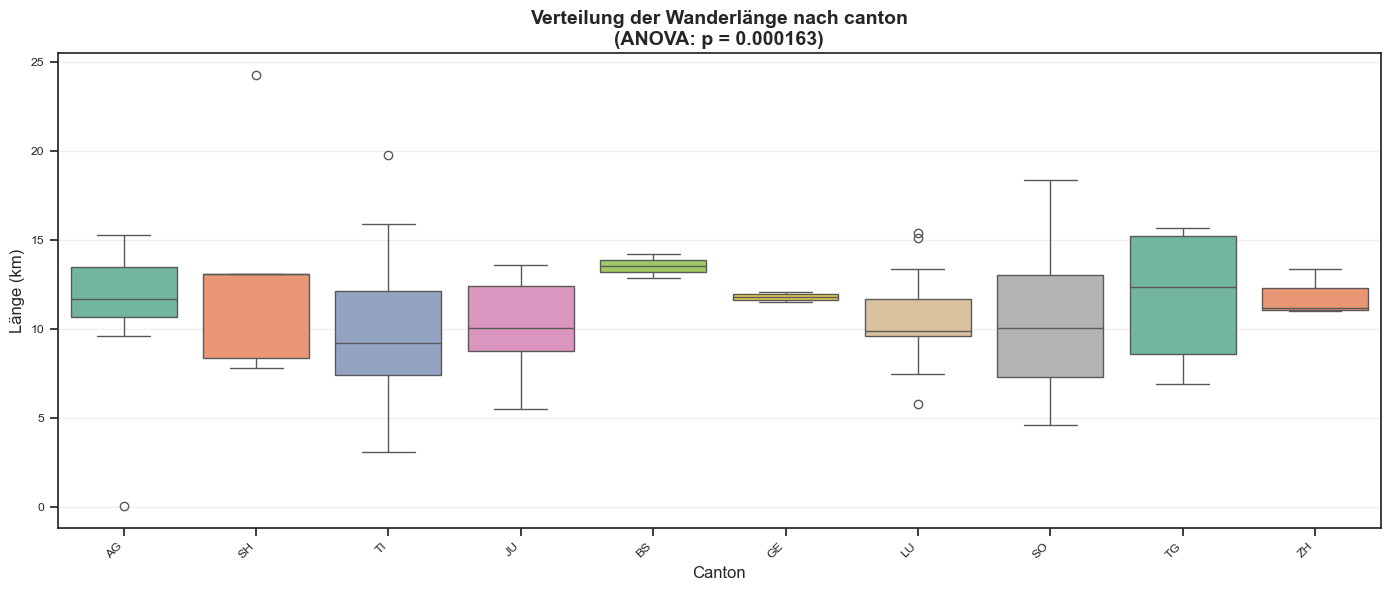

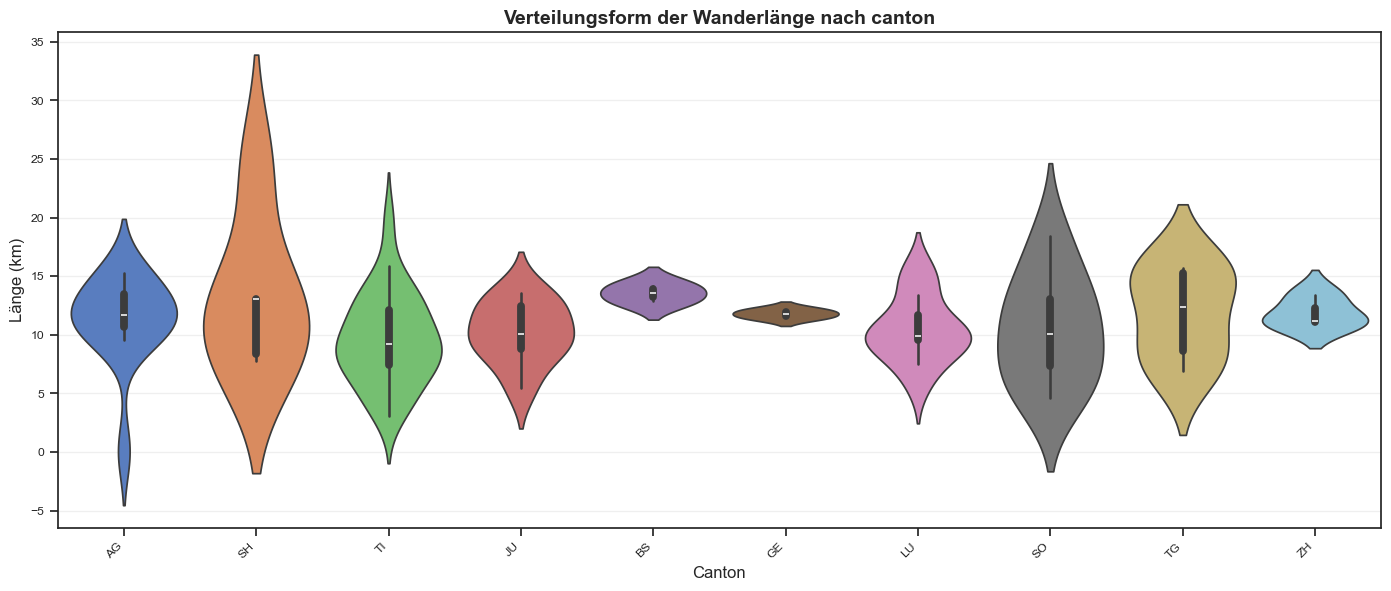

In [61]:
# Box Plot zur Visualisierung der Unterschiede
if group_col and 'distance_km' in df.columns:
    # Beschränke auf Top 10 Gruppen für bessere Lesbarkeit
    top_groups = group_stats.head(10).index.tolist()
    df_plot = df_clean[df_clean[group_col].isin(top_groups)]
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_plot, x=group_col, y='distance_km', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('Länge (km)', fontsize=12)
    plt.title(f'Verteilung der Wanderlänge nach {group_col}\n(ANOVA: p = {p_value:.6f})', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Zusätzlich: Violin Plot für detailliertere Verteilungsansicht
    plt.figure(figsize=(14, 6))
    sns.violinplot(data=df_plot, x=group_col, y='distance_km', palette='muted')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('Länge (km)', fontsize=12)
    plt.title(f'Verteilungsform der Wanderlänge nach {group_col}', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

---
# 3. Zusammenfassung der Ergebnisse

## Statistische Tests - Übersicht

In [ ]:
print("="*80)
print("ZUSAMMENFASSUNG DER STATISTISCHEN TESTS")
print("="*80)

print("\nKORRELATIONSANALYSE (Pearson)")
print("-" * 80)
if len(results_df) > 0:
    print(f"   Anzahl signifikanter Korrelationen (p < 0.05): {len(results_df)}")
    print(f"   Staerkste Korrelation: {results_df.iloc[0]['Variable 1']} <-> {results_df.iloc[0]['Variable 2']}")
    print(f"   Korrelationskoeffizient: {results_df.iloc[0]['Korrelation']:.4f}")
    print(f"   p-Wert: {results_df.iloc[0]['p-Wert']:.6f}")
else:
    print("   Keine signifikanten Korrelationen gefunden")

print("\nANOVA (Analysis of Variance)")
print("-" * 80)
if group_col:
    print(f"   Gruppierungsvariable: {group_col}")
    print(f"   Abhängige Variable: distance_km")
    print(f"   F-Statistik: {f_statistic:.4f}")
    print(f"   p-Wert: {p_value:.6f}")
    print(f"   Signifikant: {'JA' if p_value < 0.05 else 'NEIN'}")
else:
    print("   Test konnte nicht durchgeführt werden")

print("\n" + "="*80)
print("\nWICHTIG:")
print("   - p < 0.05: Statistisch signifikant (Effekt ist wahrscheinlich real)")
print("   - p ≥ 0.05: Nicht signifikant (Effekt könnte Zufall sein)")
print("   - Ein niedriger p-Wert bedeutet nicht automatisch einen wichtigen Effekt!")
print("="*80)

ZUSAMMENFASSUNG DER STATISTISCHEN TESTS

KORRELATIONSANALYSE (Pearson)
--------------------------------------------------------------------------------
   Anzahl signifikanter Korrelationen (p < 0.05): 7
   Stärkste Korrelation: distance_km ↔ duration_min
   Korrelationskoeffizient: 0.7828
   p-Wert: 0.000000

ANOVA (Analysis of Variance)
--------------------------------------------------------------------------------
   Gruppierungsvariable: canton
   Abhängige Variable: distance_km
   F-Statistik: 2.5014
   p-Wert: 0.000163
   Signifikant: JA


WICHTIG:
   - p < 0.05: Statistisch signifikant (Effekt ist wahrscheinlich real)
   - p ≥ 0.05: Nicht signifikant (Effekt könnte Zufall sein)
   - Ein niedriger p-Wert bedeutet NICHT automatisch einen wichtigen Effekt!


## Anforderung erfuellt

Dieses Notebook erfuellt die Anforderung:

> **(4) Use of a Chi-squared test or analysis of variance (ANOVA) or correlation analysis (each test must include a p-value).**

**Durchgefuehrte Tests:**
1. **Korrelationsanalyse** mit p-Werten fuer alle Variablenpaare
2. **ANOVA** mit p-Wert fuer Gruppenvergleiche

Beide Tests liefern **p-Werte** zur statistischen Signifikanzbeurteilung.